In [50]:
%matplotlib inline
from __future__ import division
from __future__ import print_function
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append("/Users/kris/Desktop/ijcai2k18/code/")
from new_code.read_data import *
from new_code.policies import *
from new_code.create_model import *
from new_code.train import *

import argparse
import tensorflow as tf

np.random.seed(1337)
from keras.backend.tensorflow_backend import set_session

config = tf.ConfigProto ()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
set_session (tf.Session (config=config))

In [2]:
import numpy as np

def decompose_kernel(L):
    D, V = np.linalg.eigh(L)
    D = np.real(D)
    D[D < 0] = 0
    idx = np.argsort(D)
    D = D[idx]
    V = np.real(V[:, idx])
    return D, V

def esym_poly(k, lam):
    N = lam.size
    E = np.zeros((k+1, N+1))
    E[0, :] = np.ones((1, N+1))
    for l in range(1, k+1):
        for n in range(1, N+1):
            E[l, n] = E[l, n-1] + lam[n-1]*E[l-1, n-1]
    return E

def expected_cardinality(lam):
    return np.sum(lam/(1+lam))

def E_Y(lam):
    return np.sum(lam/(1+lam))

def k_sample(k, lam, V_full):
    E = esym_poly(k, lam)
    J = []
    remaining = k-1
    i = lam.size-1

    while remaining>=0:
        marg = 0.0
        if i == remaining:
            marg = 1.0
        else:
            if E[remaining+1, i+1] == 0:
                i -= 1
                continue
            marg = lam[i]*E[remaining, i]/E[remaining+1, i+1]

        if np.random.rand() < marg:
            J.append(i)
            remaining -= 1

        i -= 1

    k = len(J)-1
    Y = np.zeros((len(J), 1))
    V = V_full[:, J]

    for i in range(k, -1, -1):
        # Sample
        Pr = np.sum(V**2, axis=1)
        Pr = Pr/sum(Pr)
        C = np.cumsum(Pr)
        jj = np.argwhere(np.random.rand() <= C)[0]
        Y[i] = jj

        # Update V
        j = np.argwhere(V[int(Y[i]), :])[0]
        Vj = V[:, j]
        V = np.delete(V, j, 1)
        V = V - np.outer(Vj, V[int(Y[i]), :]/Vj[int(Y[i])])

        # QR decomposition, which is more numerically stable (and faster) than Gram
        # Schmidt
        if i > 0:
            V, r = np.linalg.qr(V)

    return Y


### These Experiments indicate only minibatch diversification for a single minibatch.
### This   is the following aglorithm for our method.

Repeat for each minibatch creation.
1. sampled=[] **Set of points sampled for minibatch i**
2. model.fit(x,y) **Fit model on the full dataset**
3. for i in x:
4.   if i not in sampled: **Sampled without replacement. We have to sample without replacement in this case**
5.      score = compute score(i)
6.      max_score = max(max_score, score)**Find if i is the maximum score store it in max_idx**
7.  sampled.append(max_idx)**add max_idx to the list of sampled**

Score functions uses the uncertainity using the logistic regression.
It uses the distance measure on the original data points values.

In [3]:
from sklearn.linear_model import LogisticRegression
from scipy.stats import entropy
import operator
logistic = LogisticRegression()
def ssgd(model, x, y, batch_size):
    x=np.array(x)
    sampled=[]
    model.fit(x, y)
    score=np.zeros((len(x), 1))
    prob = logistic.predict_proba(x)
    print(prob.shape)
    for _ in range(0, batch_size):
        max_score=-sys.maxsize - 1
        max_idx=0
        for i in range(0, len(x)):  
            if i not in sampled:
                if len(sampled)==0:
                    score[i] = entropy(prob[i])
                    if score[i]>max_score:
                        max_score=score[i]
                        max_idx=i
                else:
                    prod = np.dot(x[i], x[sampled].T)
                    score[i] = entropy(prob[i])+np.mean(prod)+np.min(prod)
                    if score[i]>max_score:
                        max_score=score[i]
                        max_idx=i
        sampled.append(max_idx)
    return sampled

def flid(model, x, y, batch_size):
    x=np.array(x)
    sampled=[]
    model.fit(x, y)
    prob = logistic.predict_proba(x)
    print(prob.shape)
    for _ in range(0, batch_size):
        max_score=-sys.maxsize - 1
        max_idx=0
        for i in range(0, len(x)):  
            if i not in sampled:
                if len(sampled)==0:
                    score = entropy(prob[i])
                    if score>max_score:
                        max_score=score
                        max_idx=i
                else:
                    a=np.max(x[sampled]-np.sum(x[sampled], axis=0), axis=0)
                    a=np.sum(a)
                    tmp=sampled
                    tmp.append(i)
                    b=np.max(x[tmp]-np.sum(x[tmp], axis=0), axis=0)
                    tmp.pop()
                    b=np.sum(b)
                    score = entropy(prob[i]) + b-a
                    if score>max_score:
                        max_score=score
                        max_idx=i
        sampled.append(max_idx)
    return sampled
                    

In [5]:
org_x = np.random.uniform(0, 2, 4000)
org_y = np.random.uniform(0, 2, 4000)
data = list(zip(org_x,org_y))

In [44]:
# Creating a Subsampled Version of dataet
a, b = list(zip(*data))
p = [ abs(a[i]-b[i])**2.5 for i in range(0, len(a))]
p = p / np.sum(p)
idx = np.random.choice(np.arange(0, len(a)), 1200, replace=False, p=p)
toy_dataset = np.array(data)
a, b = list(zip(*toy_dataset[idx]))
obs_dataset = list(zip(a, b))
a=np.array(a)
b=np.array(b)

In [45]:
# Random Sampling
sampled_rnd = []
size=200
sampled_rnd.extend(np.random.choice(np.arange(0, len(a)), size, replace=True))
# Computing Number of times items sampled
df_rnd = np.zeros(([len(np.unique(sampled_rnd)), 2]))
df_rnd[:, 0], df_rnd[:,1]=np.unique(sampled_rnd, return_counts=True)
df_rnd = df_rnd.astype(np.int32)

In [29]:
# Dpp Sampling
from sklearn.metrics.pairwise import euclidean_distances, rbf_kernel
similarity_matrix = rbf_kernel(obs_dataset, gamma=0.05)
eig_val, eig_vec = np.linalg.eig(similarity_matrix)
L =similarity_matrix
D, V = decompose_kernel(L)
sampled_dpp = []
size=200
y = k_sample(size, D, V)
y = y.astype("int")
sampled_dpp.append(y)
# Computing Number of times items sampled
df_dpp = np.zeros(([len(np.unique(sampled_dpp)), 2]))
df_dpp[:, 0], df_dpp[:,1]=np.unique(sampled_dpp, return_counts=True)
df_dpp = df_dpp.astype(np.int32)

In [47]:
# Our Method
data=np.array(obs_dataset)
label=np.zeros(data.shape[0])
for k,v in enumerate(data):
    if v[1]>=1:
        label[k]=1
sampled_sgd = []
size=200
sampled_sgd.extend(ssgd(logistic, data, label, size))
df_sgd = np.zeros(([len(np.unique(sampled_sgd)), 2]))
df_sgd[:, 0], df_sgd[:,1]=np.unique(sampled_sgd, return_counts=True)
df_sgd = df_sgd.astype(np.int32)

(1200, 2)


In [48]:
#Krause Method
data=np.array(obs_dataset)
label=np.zeros(data.shape[0])
for k,v in enumerate(data):
    if v[1]>=1:
        label[k]=1
sampled_flid = []
size=200
sampled_flid.extend(flid(logistic, data, label, size))
df_flid = np.zeros(([len(np.unique(sampled_flid)), 2]))
df_flid[:, 0], df_flid[:,1]=np.unique(sampled_flid, return_counts=True)
df_flid = df_flid.astype(np.int32)

(1200, 2)


Text(0.5,1,'Krause Method')

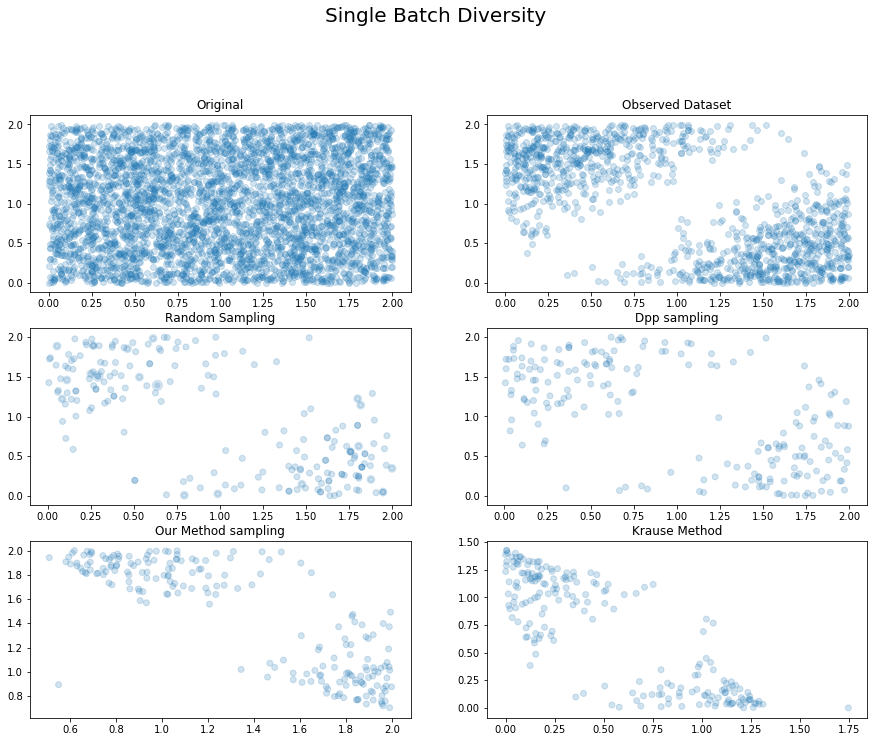

In [57]:
f = plt.figure(figsize=(15,15))
f.suptitle("Single Batch Diversity", fontsize=20)
ax0=f.add_subplot(421)
ax0.set_title("Original")
ax0.scatter(org_x, org_y, alpha=0.2)
ax = f.add_subplot(422)
ax.scatter(a, b, alpha=0.2)
ax.set_title('Observed Dataset')
ax1 = f.add_subplot(423)
ax1.scatter(a[sampled_rnd], b[sampled_rnd], alpha=0.2, linewidths=df_rnd[:, 1]**1.5)
ax1.set_title('Random Sampling')
ax2 = f.add_subplot(424)
ax2.scatter(a[sampled_dpp], b[sampled_dpp], alpha=0.2, linewidths=df_dpp[:, 1]**2)
ax2.set_title('Dpp sampling')
ax4 = f.add_subplot(425)
ax4.scatter(a[sampled_sgd], b[sampled_sgd], alpha=0.2, linewidths=df_sgd[:, 1])
ax4.set_title('Our Method sampling')
ax5 = f.add_subplot(426)
ax5.scatter(a[sampled_flid], b[sampled_flid], alpha=0.2, linewidths=df_flid[:, 1])
ax5.set_title('Krause Method')

In [96]:
from sklearn.linear_model import LogisticRegression
from scipy.stats import entropy
import operator
logistic = LogisticRegression()
sampled=[]
def ssgd_mod(model, x, y, batch_size):
    temp=[]
    x=np.array(x)
    model.fit(x, y)
    score=np.zeros((len(x), 1))
    prob = logistic.predict_proba(x)
    for _ in range(0, batch_size):
        max_score=-sys.maxsize - 1
        max_idx=0
        for i in range(0, len(x)):
            if i not in sampled:
                if len(sampled)==0:
                    score[i] = entropy(prob[i])
                    if score[i]>max_score:
                        max_score=score[i]
                        max_idx=i
                else:
                    prod = np.dot(x[i], x[sampled].T)
                    score[i] = entropy(prob[i])+np.mean(prod)+np.min(prod)
                    if score[i]>max_score:
                        max_score=score[i]
                        max_idx=i
        temp.append(max_idx)
        sampled.append(max_idx)
    return temp

def flid_mod(model, x, y, batch_size):
    x=np.array(x)
    temp=[]
    model.fit(x, y)
    prob = logistic.predict_proba(x)
    print(prob.shape)
    for _ in range(0, batch_size):
        max_score=-sys.maxsize - 1
        max_idx=0
        for i in range(0, len(x)):  
            if i not in sampled:
                if len(sampled)==0:
                    score = entropy(prob[i])
                    if score>max_score:
                        max_score=score
                        max_idx=i
                else:
                    a=np.max(x[sampled]-np.sum(x[sampled], axis=0), axis=0)
                    a=np.sum(a)
                    tmp=sampled
                    tmp.append(i)
                    b=np.max(x[tmp]-np.sum(x[tmp], axis=0), axis=0)
                    tmp.pop()
                    b=np.sum(b)
                    score = entropy(prob[i]) + b-a
                    if score>max_score:
                        max_score=score
                        max_idx=i
        temp.append(max_idx)
        sampled.append(max_idx)
    return temp
                    

In [87]:
print(len(sampled))

31116


In [60]:
# Creating a Subsampled Version of dataet
a, b = list(zip(*data))
p = [ abs(a[i]-b[i])**2.5 for i in range(0, len(a))]
p = p / np.sum(p)
idx = np.random.choice(np.arange(0, len(a)), 1200, replace=False, p=p)
toy_dataset = np.array(data)
a, b = list(zip(*toy_dataset[idx]))
obs_dataset = list(zip(a, b))
a=np.array(a)
b=np.array(b)

In [91]:
# Random Sampling
sampled_rnd = []
mini_batchsize=20
num_epoch = 10
for i in range(0, num_epoch):
    sampled_rnd.extend(np.random.choice(np.arange(0, len(a)), mini_batchsize, replace=True))
# Computing Number of times items sampled
df_rnd = np.zeros(([len(np.unique(sampled_rnd)), 2]))
df_rnd[:, 0], df_rnd[:,1]=np.unique(sampled_rnd, return_counts=True)
df_rnd = df_rnd.astype(np.int32)

In [90]:
# Dpp Sampling
sampled_dpp=[]
from sklearn.metrics.pairwise import euclidean_distances, rbf_kernel
similarity_matrix = rbf_kernel(obs_dataset, gamma=0.05)
eig_val, eig_vec = np.linalg.eig(similarity_matrix)
L =similarity_matrix
D, V = decompose_kernel(L)
sampled_dpp = []
minibatch_size=20
num_epoch=10
for i in range(0, num_epoch):
    y = k_sample(minibatch_size, D, V)
    y = y.astype("int")
    sampled_dpp.extend(y)
# Computing Number of times items sampled
df_dpp = np.zeros(([len(np.unique(sampled_dpp)), 2]))
df_dpp[:, 0], df_dpp[:,1]=np.unique(sampled_dpp, return_counts=True)
df_dpp = df_dpp.astype(np.int32)

In [78]:
# Our Method
sampled=sgd
data=np.array(obs_dataset)
label=np.zeros(data.shape[0])
for k,v in enumerate(data):
    if v[1]>=1:
        label[k]=1
sampled_sgd = []
minibatch_size=20
num_epoch = 10
for i in range(0, num_epoch):
    sampled_sgd.extend(ssgd_mod(logistic, data, label, minibatch_size))
df_sgd = np.zeros(([len(np.unique(sampled_sgd)), 2]))
df_sgd[:, 0], df_sgd[:,1]=np.unique(sampled_sgd, return_counts=True)
df_sgd = df_sgd.astype(np.int32)

In [ ]:
#Krause Method
sampled_flid=[]
data=np.array(obs_dataset)
label=np.zeros(data.shape[0])
for k,v in enumerate(data):
    if v[1]>=1:
        label[k]=1
sampled_flid = []
minibatch_size=20
num_epoch=10
for i in range(0, num_epoch):
    sampled_flid.extend(flid_mod(logistic, data, label, mini_batchsize))
df_flid = np.zeros(([len(np.unique(sampled_flid)), 2]))
df_flid[:, 0], df_flid[:,1]=np.unique(sampled_flid, return_counts=True)
df_flid = df_flid.astype(np.int32)

Text(0.5,1,'Krause Method')

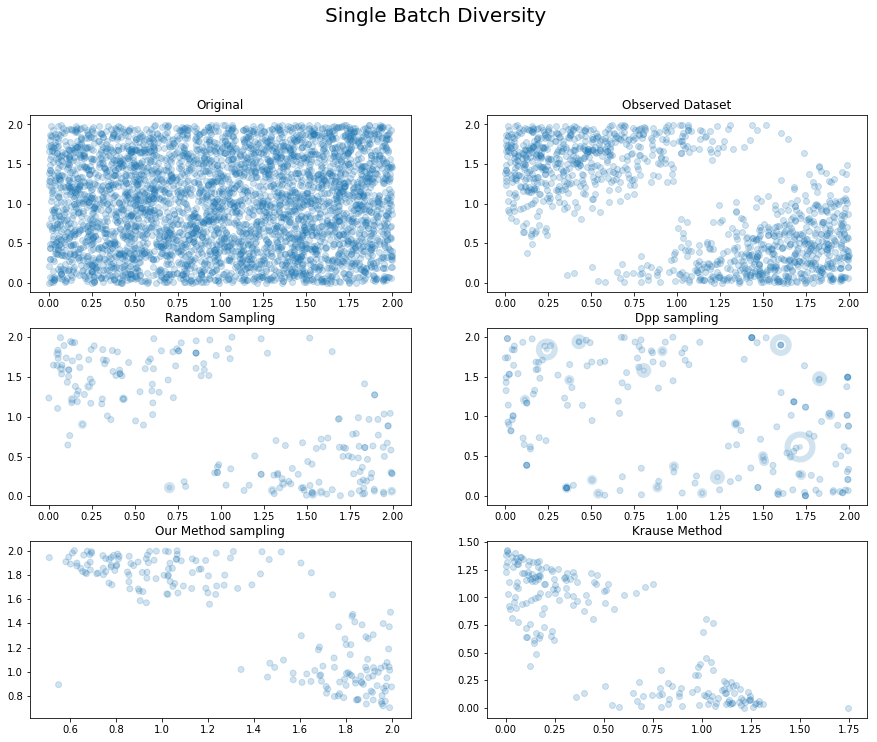

In [99]:
f = plt.figure(figsize=(15,15))
f.suptitle("Single Batch Diversity", fontsize=20)
ax0=f.add_subplot(421)
ax0.set_title("Original")
ax0.scatter(org_x, org_y, alpha=0.2)
ax = f.add_subplot(422)
ax.scatter(a, b, alpha=0.2)
ax.set_title('Observed Dataset')
ax1 = f.add_subplot(423)
ax1.scatter(a[sampled_rnd], b[sampled_rnd], alpha=0.2, linewidths=df_rnd[:, 1]**1.5)
ax1.set_title('Random Sampling')
ax2 = f.add_subplot(424)
ax2.scatter(a[sampled_dpp], b[sampled_dpp], alpha=0.2, linewidths=df_dpp[:, 1]**2)
ax2.set_title('Dpp sampling')
ax4 = f.add_subplot(425)
ax4.scatter(a[sampled_sgd], b[sampled_sgd], alpha=0.2, linewidths=df_sgd[:, 1])
ax4.set_title('Our Method sampling')
ax5 = f.add_subplot(426)
ax5.scatter(a[sampled_flid], b[sampled_flid], alpha=0.2)
ax5.set_title('Krause Method')